# Connecting with Google Drive space

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import random

# To deal witht the Directions and folders
import os
from pathlib import Path
import requests

# set the random seed
# the second thing we should set the random seed with 42 number
random.seed(42)

# I gnor the error
# The first thing we should ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# I will use it
from sklearn.metrics import cohen_kappa_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Setting some folders

In [ ]:
data_path = Path("/content/drive/MyDrive/pso_solving/Results")
if data_path.is_dir():
  print(f"The folder {data_path} is already exsiste")
else:
  print(f"The folder {data_path} is Not found Creating one..")
  data_path.mkdir(exist_ok=True)

The folder /content/drive/MyDrive/pso_solving/Results is Not found Creating one..


# Helper Functions

In [17]:
# A function to get some measurments of the model
def measurments(actual,pred,typ):
    # The fig size
    #plt.figure(figsize = (4,4))

    # Get the scores
    print(f'Accuracy Score:{accuracy_score(actual,pred)*100:.2f}%')
    print(f'Precesion Score:{precision_score(actual,pred, average="micro")*100:.2f}%')
    print(f'Recall Score:{recall_score(actual,pred, average="micro")*100:.2f}%')
    print(f'F1_Score:{f1_score(actual,pred, average="micro")*100:.2f}%')
    print(f'Kappa_Score:{cohen_kappa_score(actual,pred)*100:.2f}%')

In [18]:
# AHelper function to get and plot the confuation matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = class_names
    # simple condition
    if normalize: # == True
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm) # return the matrix

    #  start in ploting the matrix
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return ax, cm # return the figure

In [19]:
# the rest of the measurments
def rest_measurements(cf_matrix):
  """
  This function created to calculate some measurements like:
  sensitivity
  specificity
  ppv
  npv

  so enjoy with the results
  """
  total=sum(sum(cf_matrix))

  sensitivity = cf_matrix[0,0]/(cf_matrix[0,0]+cf_matrix[1,0])
  print('Sensitivity : ', round(sensitivity, 3))

  specificity = cf_matrix[1,1]/(cf_matrix[1,1]+cf_matrix[0,1])
  print('Specificity : ', round(specificity, 3))

  ppv = cf_matrix[0,0]/(cf_matrix[0,0]+cf_matrix[0,1])
  print('ppv : ', round(ppv, 3))

  npv = cf_matrix[1,1]/(cf_matrix[1,0]+cf_matrix[1,1])
  print('npv : ', round(npv, 3))

In [20]:
# Get training, validation, and testing pred with predicted probabilities
def get_pred_lst_with_prob(typ, itrs, model, sub_title):
    preds = []
    pred_probs = []  # New list to store predicted probabilities
    lab = []
    actual = []

    for i in range(itrs):
        if typ == 'training':
            res, labels = next(train_generator)
        elif typ == "validation":
            res, labels = next(val_generator)
        elif typ == "testing":
            res, labels = next(test_generator)
        else:
            print("Error")

        # Get predicted probabilities along with predicted and actual labels
        pred_probs_batch = model.predict(res, verbose=0)
        pred_probs.append(pred_probs_batch)
        preds.append(list(np.argmax(pre) for pre in pred_probs_batch))
        lab.append(list(np.argmax(l) for l in labels))

    # Concatenate the inner lists correctly
    preds = [item for sublist in preds for item in sublist]

    for l in lab:
        actual += l

    # Get the measurements for a specific model
    #measurements(actual, preds, typ.title())

    # Plot non-normalized confusion matrix
    ax, cm = plot_confusion_matrix(actual, preds, classes=class_names,
                                    title=f'Confusion matrix for {sub_title}')
    rest_measurements(cm)

    # I will use it to get the roc values
    return actual, preds, np.vstack(pred_probs)  # Use np.vstack to concatenate arrays correctly

In [39]:
# Some Configurations

class_names = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

# Dealing with the saved Dataset

In [3]:
data = pd.read_csv("/content/drive/MyDrive/pso_solving/Dataset/final_version.csv")

In [4]:
from sklearn.model_selection import train_test_split

# Split the DataFrame into train, test, and validation sets
train_data, val_data = train_test_split(data, test_size=0.10, random_state=42)

# Check the sizes of the sets
print(f"Training set size: {len(train_data)} samples")
print(f"Validation set size: {len(val_data)} samples")

Training set size: 8122 samples
Validation set size: 903 samples


In [5]:
print(train_data['Subfolder'].value_counts())
print(val_data['Subfolder'].value_counts())

Subfolder
Moderate          1628
Mild              1626
Proliferate_DR    1625
No_DR             1623
Severe            1620
Name: count, dtype: int64
Subfolder
Severe            185
No_DR             182
Proliferate_DR    180
Mild              179
Moderate          177
Name: count, dtype: int64


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the batch size and target size
batch_size = 32
target_size = (224, 224)

# Create data generators for training, validation, and testing
train_datagen = ImageDataGenerator(rescale=1. / 255)
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col="ImagePath",
    y_col="Subfolder",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
)

val_datagen = ImageDataGenerator(rescale=1. / 255)
val_generator = val_datagen.flow_from_dataframe(
    val_data,
    x_col="ImagePath",
    y_col="Subfolder",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

# Check the number of classes
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

Found 8122 validated image filenames belonging to 5 classes.
Found 903 validated image filenames belonging to 5 classes.
Number of classes: 5


In [7]:
# Converting the Dir of for storing the results
%cd /content/drive/MyDrive/pso_solving/Results

/content/drive/MyDrive/pso_solving/Results


# Building the model

In [8]:
from tensorflow.keras.applications.densenet import DenseNet121

dense = DenseNet121(input_shape=(224,224,3),weights='imagenet',include_top=False)

dense.trainable = True

set_trainable = False

for layer in dense.layers:
    if layer.name == 'conv5_block16_0_bn':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


for layer in dense.layers[:]:
  if ('bn' in layer.name):
    trainable = False

29084464/29084464 [==============================] - 0s 0us/step


In [9]:
from tensorflow.keras.layers import Dense,Flatten,Input,Dropout,Activation,BatchNormalization,Lambda
import tensorflow as tf
from tensorflow.keras.models import Model


x = Flatten()(dense.output)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
prediction = Dense(5,activation='softmax')(x)

model = Model(inputs=dense.input, outputs=prediction)

#model.summary()

In [10]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

#Early Stopping

es = EarlyStopping(monitor='val_accuracy', min_delta = 0.01, patience=5, verbose=1, mode='auto')

#Model Check Point

mc = ModelCheckpoint(monitor='val_accuracy', filepath = '/content/drive/MyDrive/pso_solving/Results/pso_solving_pso.h5', verbose=1, save_best_only = True, mode='auto')

cd = [es,mc]

In [11]:
import tensorflow
adam = tensorflow.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss='binary_crossentropy',
              optimizer = adam,
              metrics=['accuracy']#class_names = ['Severe', 'No_DR', 'Proliferate_DR', 'Mild', 'Moderate']

)

# Building the PSO

In [12]:
import copy
import numpy as np

class Particle(object):
    """Particle class for PSO

    This class encapsulates the behavior of each particle in PSO and provides
    an efficient way to do bookkeeping about the state of the swarm in any given
    iteration.

    Args:
        lower_bound (np.array): Vector of lower boundaries for particle dimensions.
        upper_bound (np.array): Vector of upper boundaries for particle dimensions.
        dimensions (int): Number of dimensions of the search space.
        objective function (function): Black-box function to evaluate.

    """
    def __init__(self,
                 lower_bound,
                 upper_bound,
                 dimensions,
                 objective_function):
        self.reset(dimensions, lower_bound, upper_bound, objective_function)

    def reset(self,
              dimensions,
              lower_bound,
              upper_bound,
              objective_function):
        """Particle reset

        Allows for reset of a particle without reallocation.

		Args:
			lower_bound (np.array): Vector of lower boundaries for particle dimensions.
			upper_bound (np.array): Vector of upper boundaries for particle dimensions.
			dimensions (int): Number of dimensions of the search space.

        """
        position = []
        for i in range(dimensions):
            if lower_bound[i] < upper_bound[i]:
                if upper_bound[i] <1 and  lower_bound[i] <1:
                    position.extend(np.random.uniform(lower_bound[i], upper_bound[i] , 1))
                else:
                    position.extend(np.random.randint(lower_bound[i], upper_bound[i] + 1, 1, dtype=int))
            elif lower_bound[i] == upper_bound[i]:
                position.extend(np.array([lower_bound[i]], dtype=int))
            else:
                assert False

        self.position = [position]

        self.velocity = [np.multiply(np.random.rand(dimensions),
                                     (upper_bound - lower_bound)).astype(float)]

        self.best_position = self.position[:]

        self.function_value = [objective_function(self.best_position[-1])]
        self.best_function_value = self.function_value[:]

    def update_velocity(self, omega, phip, phig, best_swarm_position):
        """Particle velocity update

		Args:
			omega (float): Velocity equation constant.
			phip (float): Velocity equation constant.
			phig (float): Velocity equation constant.
			best_swarm_position (np.array): Best particle position.

        """
        random_coefficient_p = np.random.uniform(size=np.asarray(self.position[-1]).shape)
        random_coefficient_g = np.random.uniform(size=np.asarray(self.position[-1]).shape)

        self.velocity.append(omega
                             * np.asarray(self.velocity[-1])
                             + phip
                             * random_coefficient_p
                             * (np.asarray(self.best_position[-1])
                                - np.asarray(self.position[-1]))
                             + phig
                             * random_coefficient_g
                             * (np.asarray(best_swarm_position)
                                - np.asarray(self.position[-1])))

        self.velocity[-1] = self.velocity[-1].astype(int)

    def update_position(self, lower_bound, upper_bound, objective_function):
        """Particle position update

		Args:
			lower_bound (np.array): Vector of lower boundaries for particle dimensions.
			upper_bound (np.array): Vector of upper boundaries for particle dimensions.
			objective function (function): Black-box function to evaluate.

        """
        new_position = self.position[-1] + self.velocity[-1]

        if np.array_equal(self.position[-1], new_position):
            self.function_value.append(self.function_value[-1])
        else:
            mark1 = new_position < lower_bound
            mark2 = new_position > upper_bound

            new_position[mark1] = lower_bound[mark1]
            new_position[mark2] = upper_bound[mark2]

            self.function_value.append(objective_function(self.position[-1]))

        self.position.append(new_position.tolist())

        if self.function_value[-1] < self.best_function_value[-1]:
            self.best_position.append(self.position[-1][:])
            self.best_function_value.append(self.function_value[-1])

class Pso(object):
    """PSO wrapper

    This class contains the particles and provides an abstraction to hold all the context
    of the PSO algorithm

    Args:
        swarmsize (int): Number of particles in the swarm
        maxiter (int): Maximum number of generations the swarm will run

    """
    def __init__(self, swarmsize=100, maxiter=2):
        self.max_generations = maxiter
        self.swarmsize = swarmsize

        self.omega = 0.5
        self.phip = 0.5
        self.phig = 0.5

        self.minstep = 1e-4
        self.minfunc = 1e-4

        self.best_position = [None]
        self.best_function_value = [0]

        self.particles = []

        self.retired_particles = []

    def run(self, function, lower_bound, upper_bound, kwargs=None):
        """Perform a particle swarm optimization (PSO)

		Args:
			objective_function (function): The function to be minimized.
			lower_bound (np.array): Vector of lower boundaries for particle dimensions.
			upper_bound (np.array): Vector of upper boundaries for particle dimensions.

		Returns:
			best_position (np.array): Best known position
			accuracy (float): Objective value at best_position
			:param kwargs:

        """
        if kwargs is None:
            kwargs = {}

        objective_function = lambda x: function(x, **kwargs)
        assert hasattr(function, '__call__'), 'Invalid function handle'

        assert len(lower_bound) == len(upper_bound), 'Invalid bounds length'

        lower_bound = np.array(lower_bound)
        upper_bound = np.array(upper_bound)

        assert np.all(upper_bound > lower_bound), 'Invalid boundary values'


        dimensions = len(lower_bound)

        self.particles = self.initialize_particles(lower_bound,
                                                   upper_bound,
                                                   dimensions,
                                                   objective_function)

        # Start evolution
        generation = 1
        while generation <= self.max_generations:
            for particle in self.particles:
                particle.update_velocity(self.omega, self.phip, self.phig, self.best_position[-1])
                particle.update_position(lower_bound, upper_bound, objective_function)

                if particle.best_function_value[-1] == 0:
                    self.retired_particles.append(copy.deepcopy(particle))
                    particle.reset(dimensions, lower_bound, upper_bound, objective_function)
                elif particle.best_function_value[-1] < self.best_function_value[-1]:
                    stepsize = np.sqrt(np.sum((np.asarray(self.best_position[-1])
                                               - np.asarray(particle.position[-1])) ** 2))

                    if np.abs(np.asarray(self.best_function_value[-1])
                              - np.asarray(particle.best_function_value[-1])) \
                            <= self.minfunc:
                        return particle.best_position[-1], particle.best_function_value[-1]
                    elif stepsize <= self.minstep:
                        return particle.best_position[-1], particle.best_function_value[-1]
                    else:
                        self.best_function_value.append(particle.best_function_value[-1])
                        self.best_position.append(particle.best_position[-1][:])



            generation += 1

        return self.best_position[-1], self.best_function_value[-1]

    def initialize_particles(self,
                             lower_bound,
                             upper_bound,
                             dimensions,
                             objective_function):
        """Initializes the particles for the swarm

		Args:
			objective_function (function): The function to be minimized.
			lower_bound (np.array): Vector of lower boundaries for particle dimensions.
			upper_bound (np.array): Vector of upper boundaries for particle dimensions.
			dimensions (int): Number of dimensions of the search space.

		Returns:
			particles (list): Collection or particles in the swarm

        """
        particles = []
        for _ in range(self.swarmsize):
            particles.append(Particle(lower_bound,
                                      upper_bound,
                                      dimensions,
                                      objective_function))
            if particles[-1].best_function_value[-1] > self.best_function_value[-1]:
                self.best_function_value.append(particles[-1].best_function_value[-1])
                self.best_position.append(particles[-1].best_position[-1])


        self.best_position = [self.best_position[-1]]
        self.best_function_value = [self.best_function_value[-1]]

        return particles

In [13]:
def func(values):
    n,do,lr = values[0],values[1],values[2]

    # Define the optimizer learning rate as a hyperparameter.
    adam = tensorflow.keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(loss='binary_crossentropy',
                  optimizer = adam,
                  metrics=['accuracy']
    )
    model.fit(train_generator,
                              steps_per_epoch=len(train_generator),
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              epochs=1,
                              callbacks= cd,
                              batch_size=32)

    #score = model.evaluate(x_test, y_test, verbose=1)
    # Evaluate the model using the test data generator
    test_loss, test_accuracy = model.evaluate_generator(val_generator)

    # traing, acc
    print('Current config:',values,'Test:',test_accuracy)
    return test_accuracy

##################################################################
pso = Pso(swarmsize=5,maxiter=2)
# n,sf,sp,l
bp,value = pso.run(func,[32,0.1,1e-4],[512,0.9,1e-3])

v = func(bp);

##################################################################

print('train loss:', bp)
print('train accuracy:', value,v)

254/254 [==============================] - ETA: 0s - loss: 0.4087 - accuracy: 0.5229
Epoch 1: val_accuracy improved from -inf to 0.68549, saving model to /content/drive/MyDrive/pso_solving/Results/pso_solving_pso.h5
254/254 [==============================] - 1481s 6s/step - loss: 0.4087 - accuracy: 0.5229 - val_loss: 0.2997 - val_accuracy: 0.6855
Current config: [493, 0.5461760164942957, 0.0003855073274177946] Test: 0.6854928135871887
254/254 [==============================] - ETA: 0s - loss: 0.2983 - accuracy: 0.6839
Epoch 1: val_accuracy improved from 0.68549 to 0.78405, saving model to /content/drive/MyDrive/pso_solving/Results/pso_solving_pso.h5
254/254 [==============================] - 69s 241ms/step - loss: 0.2983 - accuracy: 0.6839 - val_loss: 0.2345 - val_accuracy: 0.7841
Current config: [332, 0.7235618317817938, 0.00016270600950625503] Test: 0.7840531468391418
254/254 [==============================] - ETA: 0s - loss: 0.2418 - accuracy: 0.7743
Epoch 1: val_accuracy improved f

In [14]:
# Evaluate the model using the test data generator
test_loss, test_accuracy = model.evaluate_generator(val_generator, verbose=1)

print(f"Test Loss: {test_loss:.4f}")

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

29/29 [==============================] - 6s 200ms/step - loss: 0.0532 - accuracy: 0.9535
Test Loss: 0.0532
Test Accuracy: 95.35%


In [15]:
from tensorflow.keras.models import load_model

model_2 = load_model("/content/drive/MyDrive/pso_solving/Results/pso_solving_pso.h5")

In [16]:
# Evaluate the model using the test data generator
test_loss, test_accuracy = model_2.evaluate_generator(val_generator, verbose=1)

print(f"Test Loss: {test_loss:.4f}")

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

29/29 [==============================] - 9s 204ms/step - loss: 0.0557 - accuracy: 0.9601
Test Loss: 0.0557
Test Accuracy: 96.01%


Confusion matrix, without normalization
[[175   4   0   0   0]
 [  6 157   1   8   5]
 [  1   5 176   0   0]
 [  0   0   0 178   2]
 [  0   0   0   4 181]]
Sensitivity :  0.967
Specificity :  0.975
ppv :  0.978
npv :  0.963


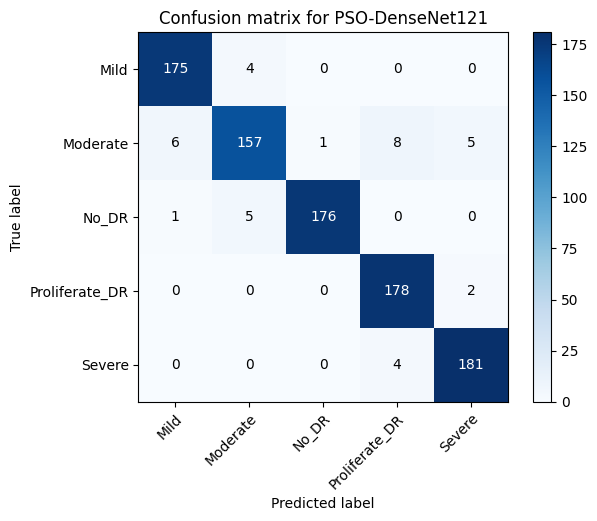

In [42]:
# Get actual labels, predicted labels, and predicted probabilities
actual_test, preds_test, pred_probs_test = get_pred_lst_with_prob("validation", 29, model_2,"PSO-DenseNet121")

In [43]:
measurments(actual_test, preds_test, type)

Accuracy Score:96.01%
Precesion Score:96.01%
Recall Score:96.01%
F1_Score:96.01%
Kappa_Score:95.02%


In [44]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(actual_test, preds_test, target_names=class_names)

# Print the classification report
print(report)

                precision    recall  f1-score   support

          Mild       0.96      0.98      0.97       179
      Moderate       0.95      0.89      0.92       177
         No_DR       0.99      0.97      0.98       182
Proliferate_DR       0.94      0.99      0.96       180
        Severe       0.96      0.98      0.97       185

      accuracy                           0.96       903
     macro avg       0.96      0.96      0.96       903
  weighted avg       0.96      0.96      0.96       903



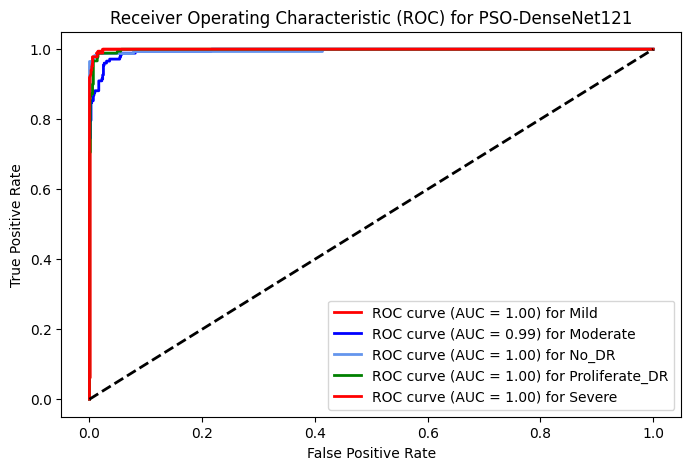

In [45]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from itertools import cycle

# Assuming actual_train_tr is the true labels and pred_probs_train is the predicted probabilities
# Convert labels to binary matrix
binary_labels = label_binarize(actual_test, classes=range(len(class_names)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(binary_labels[:, i], pred_probs_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for all classes
plt.figure(figsize=(8, 5))

colors = cycle(['red', 'blue', 'cornflowerblue', 'green'])  # Add more colors as needed
for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (AUC = {roc_auc[i]:.2f}) for {class_names[i]}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Plot the diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for PSO-DenseNet121')
plt.legend(loc='lower right')
plt.show()
